In [205]:
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors

from sklearn import model_selection as ms
from sklearn import ensemble
import matplotlib.pyplot as plt
from rdkit.Chem import Draw
import math
import numpy as np
from sklearn.metrics import mean_squared_error
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit import DataStructs
from scipy.cluster.hierarchy import complete, fcluster,dendrogram, linkage
from sklearn.decomposition import PCA

Reads data (does not include molecules with empty field for activity, activity units or canonical smiles)

In [209]:
mols = []
empty = 0

with open("bioactivity-CB1_receptor.txt") as file:
    for line in file:
        cols = line.strip().split("\t")
        tup = [cols[0],Chem.MolFromSmiles(cols[10]),cols[14]]
        if not tup[0]:
            empty += 1
        else:
            if not tup[1]:
                empty += 1
            else:
                if not tup[2]:
                    empty += 1
                else:
                    mols.append(tup)
print(empty)
print(len(mols))

1091
3990


Filter: Exclude inorganic compounds and molecules with Ki higher than 10 microM

In [211]:
idx = []
activities = []
filtered_mols = []
for i,mol in enumerate(mols):
    if float(mol[2]) < 10000:
        if not mol[1].HasSubstructMatch(Chem.MolFromSmarts("[!#6;!#7;!#8;!#9;!#17;!#35;!#53;!#16]")):
            idx.append(i)
for i in idx:
    filtered_mols.append(mols[i][1])
    activities.append(float(mols[i][2]))
print(len(filtered_mols))
pvals = [-math.log10(val) for val in activities]

3306


Calculates atributes of molecules for modeling

In [212]:
fps = [AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=512) for m in filtered_mols]
mqns = [rdMolDescriptors.MQNs_(m) for m in filtered_mols]
MACCs = [rdMolDescriptors.GetMACCSKeysFingerprint(m) for m in filtered_mols]
all_des = np.column_stack((fps,mqns,MACCs))

3306


In [213]:
trainset, testset = ms.train_test_split(list(zip(all_des,pvals)))
print(len(trainset))
print(len(testset))

2479
827


In [214]:
good_model = ensemble.RandomForestRegressor()
good_model.fit([all_des for all_des,pvals in trainset],[pvals for all_des,pvals in trainset])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [215]:
test_predictions = good_model.predict([all_des for all_des,pvals in testset])

In [216]:
def plot(X, *args, highlights=set()):
    fig = plt.figure()
    #ax = plt.subplot(111)
    for i, point in enumerate(X):
        x,y = point
        if i in highlights:
            plt.plot([x],[y],"r.", markersize=4)
        else:
            plt.plot([x],[y],"k.", markersize=1)
    plt.show()

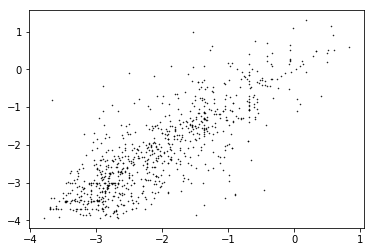

In [217]:
plot(zip(test_predictions,[pvals for all_des,pvals in testset]))

In [218]:
print("R^2: %0.2f" % good_model.score([all_des for all_des,pvals in testset], [pvals for all_des,pvals in testset]))
print("R: %0.2f" % np.sqrt(good_model.score([all_des for all_des,pvals in testset], [pvals for all_des,pvals in testset])))
print("MSE: %0.2f" %  mean_squared_error(good_model.predict([all_des for all_des,pvals in testset]), [pvals for all_des,pvals in testset]))

R^2: 0.65
R: 0.81
MSE: 0.45


Analysis

In [219]:
def make_graph_scaffold(mol):
    Chem.rdmolops.RemoveStereochemistry(mol)
    atomic_scaffold = MurckoScaffold.GetScaffoldForMol(mol)
    try:
        Chem.SanitizeMol(atomic_scaffold)
        graph_scaffold = MurckoScaffold.MakeScaffoldGeneric(atomic_scaffold)
    except ValueError:
        return None
    return graph_scaffold

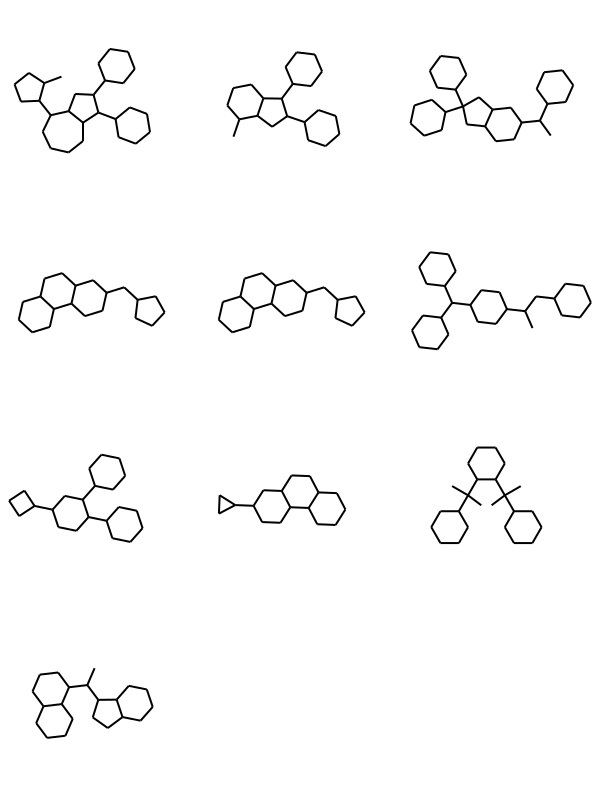

In [220]:
graph_scaffolds = [make_graph_scaffold(m) for m in filtered_mols]
Draw.MolsToGridImage(graph_scaffolds[20:30])

In [221]:
len(graph_scaffolds), len([x for x in graph_scaffolds if x])

(3306, 3306)

In [223]:
dist_matrix = []
for i,n in enumerate(fps):
    row = []
    for j,m in enumerate(fps):
        row.append(DataStructs.FingerprintSimilarity(fps[i],fps[j], metric=DataStructs.TanimotoSimilarity))
    dist_matrix.append(row)

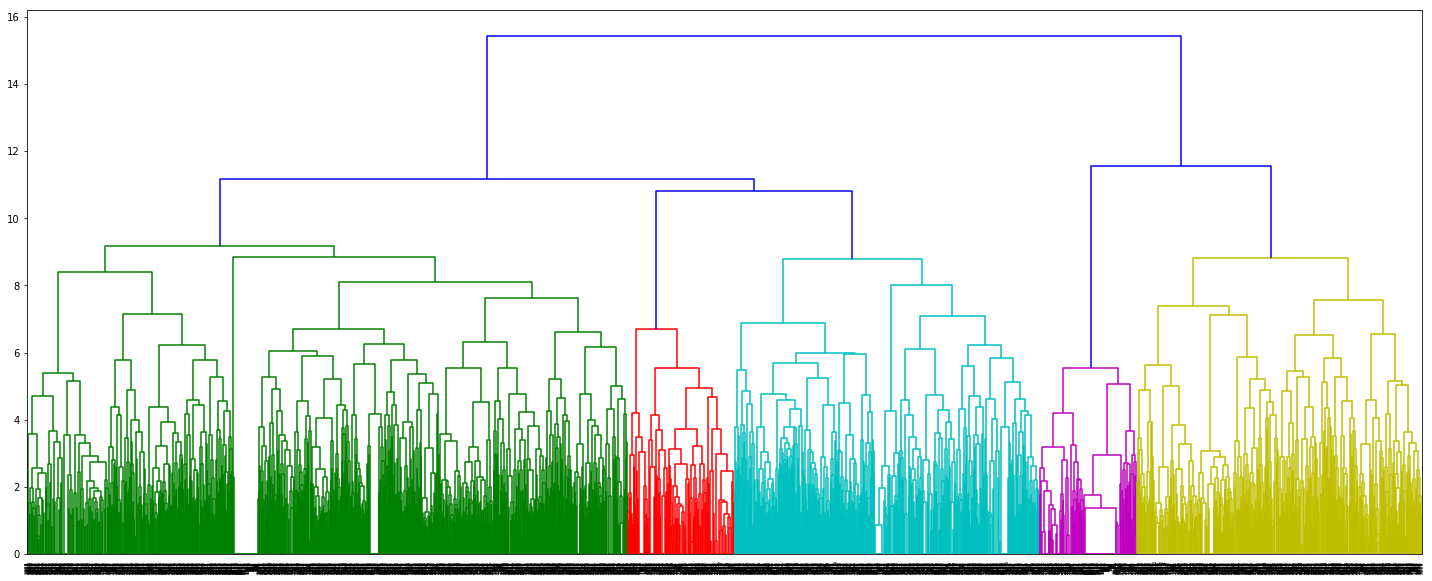

In [224]:
d = complete(dist_matrix)
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(d)
plt.show()

In [225]:
clusters = fcluster(d, 5, criterion='maxclust')

In [226]:
hbas = [rdMolDescriptors.CalcNumLipinskiHBA(m) for m in filtered_mols]
hbds = [rdMolDescriptors.CalcNumLipinskiHBD(m) for m in filtered_mols]
logPs = [Chem.Descriptors.MolLogP(m) for m in filtered_mols]
X = np.column_stack((fps,mqns,MACCs,hbas,hbds,logPs))
pca = PCA(n_components = 2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [227]:
print(pca.explained_variance_ratio_)

[0.34388046 0.22239951]


In [228]:
projected = pca.fit_transform(X)

PCA, color according to activity

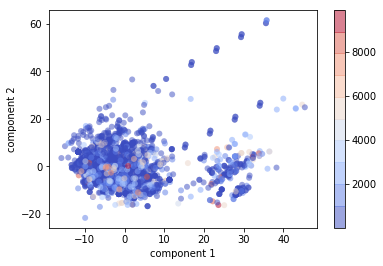

In [231]:
plt.scatter(projected[:, 0], projected[:, 1],
            c=activities,edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('coolwarm', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

PCA, color according to clusters based on Morgan fingerprints

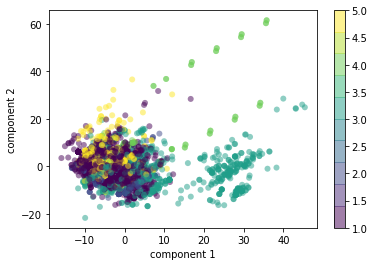

In [232]:
plt.scatter(projected[:, 0], projected[:, 1],
            c=clusters,edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('viridis', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();